# Notebook ?: Investigate PRISM alternative Daymet

## Install/import packages

In [ ]:
#!pip install pyDaymet 

In [1]:
import pydaymet as daymet
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import hydrofunctions as hf
%matplotlib inline

## Get basin geometry

In [2]:
# from data download notebook
def get_basin_data(gaugeID, featureSource='nwissite'):
    basin_url = f'https://labs.waterdata.usgs.gov/api/nldi/linked-data/{featureSource}/USGS-{gaugeID}/basin'
    
    # get shapefile of gauge basin
    basin_gdf = gpd.read_file(basin_url)
    return basin_gdf

In [3]:
everson_gdf = get_basin_data(gaugeID = '12211200')
geometry = everson_gdf.geometry[0]

## Get precip and SWE from Daymet

In [4]:
start_date = "2021-11-10"
end_date = "2021-12-10"
date_list = pd.date_range(start_date, end_date).to_list()

var = ["prcp", "swe"]
dates = (start_date, end_date)

daily = daymet.get_bygeom(geometry, dates, variables=var, snow=True)

In [5]:
daily

<xarray.Dataset>
Dimensions:                  (time: 31, y: 50, x: 58)
Coordinates:
  * time                     (time) datetime64[ns] 2021-11-10 ... 2021-12-10
  * y                        (y) float32 897.0 896.0 895.0 ... 850.0 849.0 848.0
  * x                        (x) float32 -1.553e+03 -1.552e+03 ... -1.496e+03
    lambert_conformal_conic  int64 0
Data variables:
    tmin                     (time, y, x) float32 dask.array<chunksize=(31, 50, 58), meta=np.ndarray>
    lat                      (y, x) float64 dask.array<chunksize=(50, 58), meta=np.ndarray>
    lon                      (y, x) float64 dask.array<chunksize=(50, 58), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(31, 50, 58), meta=np.ndarray>
    prcp                     (time, y, x) float32 dask.array<chunksize=(31, 50, 58), meta=np.ndarray>
    snow                     (time, y, x) float32 dask.array<chunksize=(31, 50, 58), meta=np.ndarray>
Attributes:
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor...
    start_year:          2021
    source:              Daymet Software Version 4.0
    Version_data:        Daymet Data Version 4.0
    Version_software:    Daymet Software Version 4.0
    Conventions:         CF-1.6
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  48.42354352530044
    geospatial_lat_max:  49.186090338698406
    geospatial_lon_min:  -122.55369837940518
    geospatial_lon_max:  -121.33909330470777

## Plot precipitation and SWE, to see what it looks like

In [6]:
#daily['prcp'].isel(time = range(31)).plot.imshow(col = 'time', col_wrap = 4)

In [7]:
#daily['swe'].isel(time = range(31)).plot.imshow(col = 'time', col_wrap = 4, vmax = 50)

## Calculate Daily Volume Change in SWE

In [8]:
daily_snow_delta = []
for i in range(31):
    change_in_snow = daily['swe'].isel(time=i) - daily['swe'].isel(time=(i-1))
    time = date_list[i]
    
    change_in_snow = change_in_snow.expand_dims(dim = 'time')
    change_in_snow.coords['time'] = ('time', [time])
    
    daily_snow_delta.append(change_in_snow)

In [9]:
daily_snow_delta = xr.concat(daily_snow_delta, dim = 'time')

In [10]:
daily_snow_delta

<xarray.DataArray 'swe' (time: 31, y: 50, x: 58)>
dask.array<concatenate, shape=(31, 50, 58), dtype=float32, chunksize=(1, 50, 58), chunktype=numpy.ndarray>
Coordinates:
  * y                        (y) float32 897.0 896.0 895.0 ... 850.0 849.0 848.0
  * x                        (x) float32 -1.553e+03 -1.552e+03 ... -1.496e+03
    lambert_conformal_conic  int64 0
  * time                     (time) datetime64[ns] 2021-11-10 ... 2021-12-10

## Calculate daily volume of river discharge

In [11]:
discharge_df = pd.read_parquet('discharge_data/everson.parquet', engine = 'pyarrow')

In [12]:
daily_discharge_volume = discharge_df['USGS:12211200:00060:00003']*60*60*24/35.314666212661

In [13]:
daily_gridded_precip_volume = daily['prcp'] * 1000 * 1000 * (10**-3)
daily_gridded_swe_volume = daily_snow_delta * 1000 * 1000 / 997

In [14]:
daily_gridded_runoff_volume = daily_gridded_precip_volume - daily_gridded_swe_volume

In [15]:
daily_total_runoff  = daily_gridded_runoff_volume.sum(dim = ('y', 'x'))

In [16]:
perc_diff = 100*(daily_total_runoff - daily_discharge_volume)/daily_discharge_volume

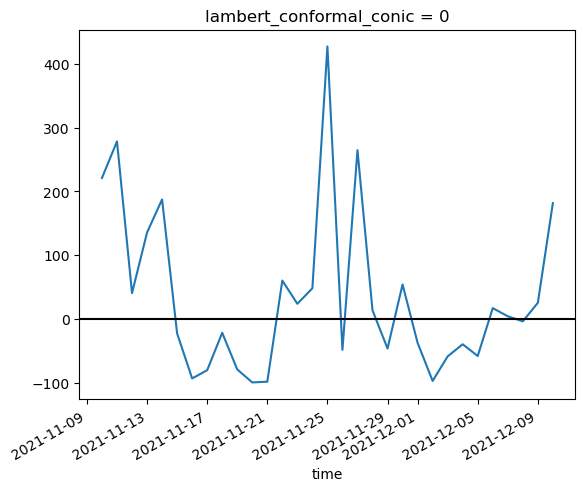

In [20]:
perc_diff.plot()
plt.axhline(0, color = 'k')

In [18]:
perc_diff

<xarray.DataArray (time: 31)>
array([220.96045868, 278.267416  ,  40.57225238, 135.55068357,
       187.3274602 , -22.61148902, -93.11601998, -80.24761072,
       -21.58441054, -78.97763817, -99.37594218, -98.22286926,
        60.25312535,  23.80809162,  48.21279081, 427.10821035,
       -48.27235439, 264.57507988,  13.56513688, -46.2268292 ,
        54.09166375, -37.34036006, -97.08907877, -58.57873734,
       -39.55768619, -58.00458746,  17.03746569,   4.26324296,
        -3.65037984,  25.35005833, 181.61299305])
Coordinates:
  * time                     (time) datetime64[ns] 2021-11-10 ... 2021-12-10
    lambert_conformal_conic  int64 0